Recommendation:

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data.csv', encoding = 'unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
df.shape

(541909, 8)

In [4]:
#data wrangling and preprocessing
#removing mising values
df.isnull().sum()
df.dropna(inplace=True)

In [5]:
df['StockCode']= df['StockCode'].astype(str)
#checking number of customers 
customers = df["CustomerID"].unique().tolist()
len(customers)


4372

In [6]:
# extract customer ID's
customers_train = [customers[i] for i in range(len(customers))]
train_df = df[df['CustomerID'].isin(customers_train)]


In [7]:
# list to capture purchase history of the customers
purchases_train = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)


100%|████████████████████████████████████████████████████████████████████████████| 4372/4372 [00:02<00:00, 1939.26it/s]


In [8]:
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)
model.save("word2vec_2.model")
model.init_sims(replace=True)
print(model)

Word2Vec<vocab=3208, vector_size=100, alpha=0.03>


In [9]:
# extract all vectors
# X = model[model.wv.vocab]
X = list(model.wv.index_to_key)
lst = []
for idx, key in enumerate(X):
    lst.append(model.wv[key]) 

In [10]:
len(lst)

3208

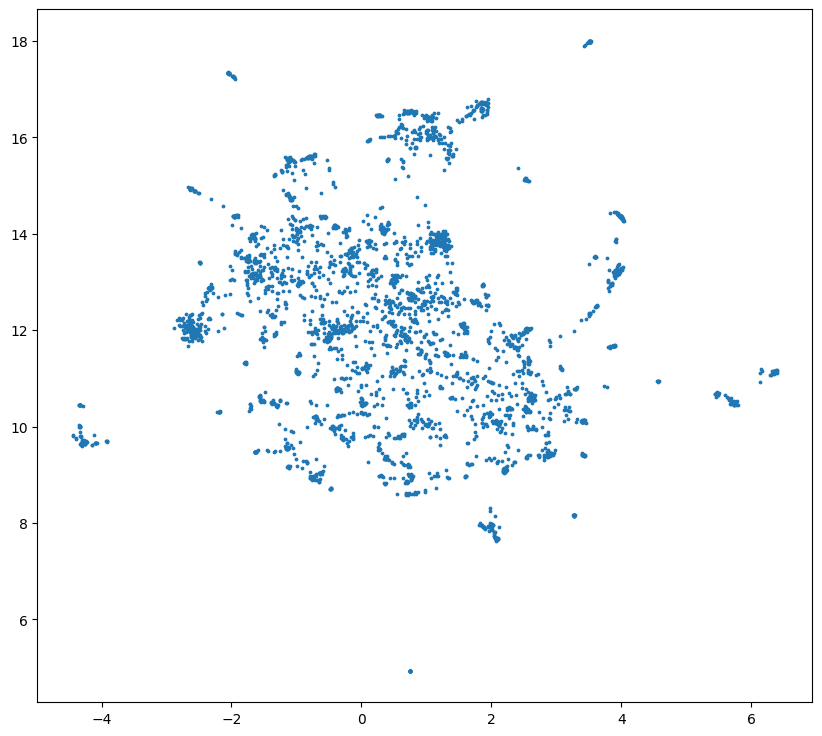

In [11]:
#REDUCING DIMENSIONS
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(lst)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [12]:
X= lst

In [13]:
products = train_df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()


In [14]:
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

In [15]:

def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.wv.most_similar(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms
   

In [16]:
 #suggesting similar products based on single product
 similar_products(['84406B'])

[('ENCHANTED BIRD COATHANGER 5 HOOK', 0.693827211856842),
 ('FOUR HOOK  WHITE LOVEBIRDS', 0.6758151054382324),
 ('SALLE DE BAIN HOOK', 0.6011090874671936),
 ('REGENCY MIRROR WITH SHUTTERS', 0.5481923818588257),
 ('YELLOW COAT RACK PARIS FASHION', 0.5465381145477295),
 ('SWEETHEART WIRE MAGAZINE RACK', 0.540962815284729)]

In [17]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model.wv[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)


In [18]:
customer_id_to_whom_products_need_to_be_suggested=float(input('Enter the customer id'))

Enter the customer id17850.0	


In [19]:
#products recommendation based on customers whole purchase history
#idea here is to take aggregate of all the purchase products' vector representation 
#and then recommend most similar products using cosine similarity
similar_products(
    aggregate_vectors(
        purchases_train[
            customers_train.index(
                customer_id_to_whom_products_need_to_be_suggested
            )
        ]
    )
)

[('WOOD 2 DRAWER CABINET WHITE FINISH', 0.7012412548065186),
 ('WOODEN FRAME ANTIQUE WHITE ', 0.6974564790725708),
 ('CREAM HANGING HEART T-LIGHT HOLDER', 0.6786434650421143),
 ('VINTAGE BILLBOARD DRINK ME MUG', 0.6762995719909668),
 ('RED WOOLLY HOTTIE WHITE HEART.', 0.6695504188537598),
 ('WOODEN PICTURE FRAME WHITE FINISH', 0.6675200462341309)]

In [20]:
##products recommendation based on customers 10 most reent purchases
#the number on the side denotes similarity which my not be printed if not wanted
similar_products(aggregate_vectors(purchases_train[customers_train.index(customer_id_to_whom_products_need_to_be_suggested)][-10:]))

[('3 DRAWER ANTIQUE WHITE WOOD CABINET', 0.7723449468612671),
 ('WOODEN FRAME ANTIQUE WHITE ', 0.7232072949409485),
 ('WOODEN PICTURE FRAME WHITE FINISH', 0.6971591114997864),
 ('WOOD BLACK BOARD ANT WHITE FINISH', 0.6881033182144165),
 ('CREAM HANGING HEART T-LIGHT HOLDER', 0.6737111210823059),
 ('GLASS STAR FROSTED T-LIGHT HOLDER', 0.6733490824699402)]

Review:

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.colors as colors
import warnings
from scipy import stats
warnings.filterwarnings('ignore')


In [22]:
review_df = pd.read_json(r"C:\Users\harsh\Downloads\reviews_All_Electronics.json.gz", orient='records', lines=True)
review_df = review_df.rename(columns={'overall': 'Rating'})
review_df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,Rating,summary,unixReviewTime,reviewTime
0,AI9M1HBD188VK,0324322402,Brandy,"[1, 1]",This device worked very nicely for the large c...,4,Clicker,1327881600,"01 30, 2012"
1,A3E7PG9CHDBICA,059403390X,Amazonian,"[0, 0]",A beautiful cover that feels great to hold in ...,5,Color Cover,1403827200,"06 27, 2014"
2,A32JCI4AK2JTTG,059403390X,"Darryl Bennett ""Fuzzy342""","[0, 2]",I think that this is a very nice and economica...,5,Nook Simple Touch Industiral Cover.,1356480000,"12 26, 2012"
3,A15J2ESU6EMNTE,059403390X,J. VanderZiel,"[1, 2]",This is a good quality case and was reasonably...,4,Good cover but does *not* act as support for Nook,1357171200,"01 3, 2013"
4,A2BTN4KV00ZKTF,059403390X,Richard W.,"[0, 0]",I bought this for my wife to protect her Nook ...,5,Very sleek and stylish cover,1400198400,"05 16, 2014"


In [23]:
#meta data of the products reviewed
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

dfmeta = getDF(r"C:\Users\harsh\Downloads\meta_All_Electronics.json.gz")
dfmeta.head()

,asin,categories,description,title,price,salesRank,imUrl,related,brand
0,0324322402,[[All Electronics]],"Optimized for small, medium and large presenta...",ResponseCard IR,56.99,{'Electronics': 111352},http://ecx.images-amazon.com/images/I/51QBqN3F...,"{'also_viewed': ['B0018RRSOU'], 'buy_after_vie...",NaN
1,059403390X,[[All Electronics]],The Barnes &amp;amp; Noble BP-01-C01-N2-1 Indu...,Barnes &amp; Noble BP-01-C01-N2-1 Industriell ...,15.00,{'Electronics': 49531},http://ecx.images-amazon.com/images/I/5145WahS...,"{'also_bought': ['B005HM8BRU', '0594033918', '...",NaN
2,0594450268,[[All Electronics]],NOOK HD+ PROTECTIVE STAND COVER. CUSOM DESIGNE...,NOOK HD+ Protective Stand Cover,25.78,{'Electronics': 16038},http://ecx.images-amazon.com/images/I/31x1Kj7y...,"{'also_bought': ['B00AK2MHEU', 'B00AFYBTSI', '...",NaN
3,0972980008,[[All Electronics]],NaN,Rosary Reflections for Kids - Tablet,NaN,{'Electronics': 130742},http://ecx.images-amazon.com/images/I/41KTZKJ6...,NaN,NaN
4,1001525191,[[All Electronics]],NaN,I love you so madly. Romances and Russian folk...,NaN,{'Electronics': 701175},http://ecx.images-amazon.com/images/I/51nFhVkj...,NaN,NaN


In [24]:
#merging reviews and metadata
product_reviews=pd.merge(review_df,dfmeta,how='left')
product_reviews.isnull().sum()
product_reviews2=product_reviews.dropna(subset=['title'])

In [25]:
#uniue products in dataset whose reviews were given
product_reviews2.title.unique()

array(['ResponseCard IR',
       'Barnes &amp; Noble BP-01-C01-N2-1 Industriell Cover',
       'NOOK HD+ Protective Stand Cover', ...,
       'Nook Color Tablet USB Charge Cable Latest Generation Cable With Secure Fit Updated Design',
       '6.35mm Stereo Plug to 2x6.35mm Mono Jack Adapter',
       'Express Backpack - Blk/wht'], dtype=object)

In [26]:
# We want to analyse reviews of a singl product and suggest insights from them to the producer,
# the product can be anything whose reviews are available in the dataset.
# Let's choose headphones for demonstration purpose, in relity it will be a particular company product.
# So, now extracting information of a headphone from the data
product_reviews_hp = product_reviews2[product_reviews2["title"].str.contains("headphones|headphone|Headphones|Headphone")]
product_reviews_hp.shape

(755, 17)

In [27]:
# CHECKING FOR MISSING VALUES
product_reviews_hp.isnull().sum()
# FILLING NULL VALUES IN BRAND NAME WITH FIRST WORD FROM TITLE
product_reviews_hp.loc[product_reviews_hp.brand.isnull(),'brand'] = product_reviews_hp.title.str.split().str.get(0)

In [28]:
#deleting non important columns and null value columns
product_reviews_hp2=product_reviews_hp.drop('salesRank',axis=1)
product_reviews_hp3=product_reviews_hp2.dropna(subset=['reviewerName','description','price','related'])
# CONCATENATE REVIEWTEXT AND SUMMARY SINCE BOTH ARE USEFUL FOR ANALYSING
product_reviews_hp3['review_text'] = product_reviews_hp3[['summary', 'reviewText']].apply(lambda x: " ".join(str(y) for y in x if str(y) != 'nan'), axis = 1)
product_reviews_hp4 = product_reviews_hp3.drop(['reviewText', 'summary'], axis = 1)
product_reviews_hp4.head()


,reviewerID,asin,reviewerName,helpful,Rating,unixReviewTime,reviewTime,categories,description,title,price,imUrl,related,brand,review_text
11402,A10QVMFIQ5KPVI,B0006TNNLS,Charles Norwood Wood III,"[0, 0]",1,1403654400,"06 25, 2014",[[All Electronics]],Headphone - Amplifier,Whirlwind PA-1 Battery Operated Personal Headp...,201.00,http://ecx.images-amazon.com/images/I/41Xw7AwD...,"{'also_viewed': ['B0002BG2SQ', 'B000KUCQXY'], ...",Whirlwind,Huge let down Bought a set of these for stage ...
17433,A1VUFUAD94QX4V,B000I3C5IO,J. Duncan,"[0, 2]",2,1199836800,"01 9, 2008",[[All Electronics]],Allows 2 headphones to be used on 1 device3.5m...,Duplex Headphone Adapter (Discontinued by Manu...,7.17,http://ecx.images-amazon.com/images/I/41eLTnIq...,"{'also_bought': ['B00DBEBEHU', 'B009LRBLV0', '...",Duplex,"May not work with your TV Good idea, but did n..."
18850,A1H5DWUW49S3XA,B000K1Q0TE,Nugget's Mom,"[1, 1]",3,1358121600,"01 14, 2013",[[All Electronics]],Audio Dots have great fidelity and a slimline ...,Polar Fusion Audio Dots: Instant Hat or Helmet...,13.97,http://ecx.images-amazon.com/images/I/51EzdC-u...,"{'buy_after_viewing': ['B009QFZI48', 'B006PV5X...",Polar,"Sound is decent, fit isn't all that easy My bo..."
18851,A5XI779YAR8WN,B000K1Q0TE,Shelley Monaghan,"[1, 1]",5,1320192000,"11 2, 2011",[[All Electronics]],Audio Dots have great fidelity and a slimline ...,Polar Fusion Audio Dots: Instant Hat or Helmet...,13.97,http://ecx.images-amazon.com/images/I/51EzdC-u...,"{'buy_after_viewing': ['B009QFZI48', 'B006PV5X...",Polar,Great set of replacment ear phones I have been...
18852,A3OPDDIW1P2FEM,B000K1Q0TE,Timothy M. Appleman,"[1, 1]",5,1302307200,"04 9, 2011",[[All Electronics]],Audio Dots have great fidelity and a slimline ...,Polar Fusion Audio Dots: Instant Hat or Helmet...,13.97,http://ecx.images-amazon.com/images/I/51EzdC-u...,"{'buy_after_viewing': ['B009QFZI48', 'B006PV5X...",Polar,polar fusion audio dots They worth buying. I h...


In [29]:
#We consider rating 4 and 5 as good/positive review ,1 and 2 as bad as negative/bad review and 3 as neutral
good_rate_no = len(product_reviews_hp4[product_reviews_hp4['Rating'] >= 4 ])
bad_rate_no = len(product_reviews_hp4[product_reviews_hp4['Rating'] < 3])
good_rate = product_reviews_hp4[product_reviews_hp4['Rating'] >= 4 ]
bad_rate = product_reviews_hp4[product_reviews_hp4['Rating'] < 3]
neutral = product_reviews_hp4[product_reviews_hp4['Rating'] == 3]
# Printing rates and their total numbers
print ('Good ratings : {} reviews for Heaphones products'.format(good_rate))
print ('Bad ratings : {} reviews for Headphones products'.format(bad_rate))

Good ratings :            reviewerID        asin                 reviewerName helpful  \
18851   A5XI779YAR8WN  B000K1Q0TE             Shelley Monaghan  [1, 1]   
18852  A3OPDDIW1P2FEM  B000K1Q0TE          Timothy M. Appleman  [1, 1]   
35168  A34EUI8084E9HY  B002QWJ1WS        jauuneken "hidd@rm&o"  [0, 0]   
35172  A1FQTNE2NHFN6G  B002QWJ1WS                         Toby  [0, 0]   
36498  A1PIJ1TN418X3Z  B0033PRORG                            B  [0, 0]   
...               ...         ...                          ...     ...   
72574  A3VUKR7DCUJQUB  B00HCE9GLQ                       Josh J  [0, 0]   
72577  A3CB6DTWN5JKGW  B00HCE9GLQ  Nancy O'Shea "The Lamppost"  [0, 0]   
72579  A34GWSEGAZATPQ  B00HCE9GLQ                roberta scott  [0, 0]   
72580  A1Z9Q2CMLLHS5T  B00HCE9GLQ              Thomas Hennessy  [0, 0]   
72581  A31Z4501A20IM2  B00HCE9GLQ              van dinh nguyen  [0, 0]   

       Rating  unixReviewTime   reviewTime           categories  \
18851       5      1320192000

In [30]:
#dropping duplicates
product_reviews_hp4 = product_reviews_hp4.drop_duplicates(['asin','reviewerName', 'unixReviewTime'], keep = 'first')

In [31]:
#algorithm for suggestion in change of price based on review/ratings 
#which will bw only valid if the number of purchases have exceeded a certain threshhold decided by the seller
#because if the purchases are very few the price has to be definitely decreased
percent_good= good_rate_no / (good_rate_no + bad_rate_no)#only calculated using good and bad
factor=0.5 # 0.5 is for example , factor is actually decided by the seller
percent_increase_in_price= factor * (percent_good-50) 
#so if the percent of positive reviews is 50, no. of positive and negative reviews are equal then no need t o change price
# so we calculate the exceed of positive reviews from 50 and multiply factor to get the increase in price 
#factor helps us to decide what shouldbe the maximum increase in price , in this case since factor is 0.5 
#the maximum increase in pice is suggested is 25 which would occur when perent of positive reviews is 100


In [32]:
#now we derive inputs from text reviews and depict the areas which are good and areas which need improvement
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

In [33]:
review_words_good = '' 
stopwords = set(STOPWORDS) 
#Stopwords are the English words which does not add much meaning to a sentence.
#They can safely be ignored without sacrificing the meaning of the sentence. 
#For example, the words like the, he, have etc. Such words are already captured this in corpus named corpus.
for val in good_rate.review_text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    review_words_good += " ".join(tokens)+" "
review_words_bad=''
for val in bad_rate.review_text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    review_words_bad += " ".join(tokens)+" "

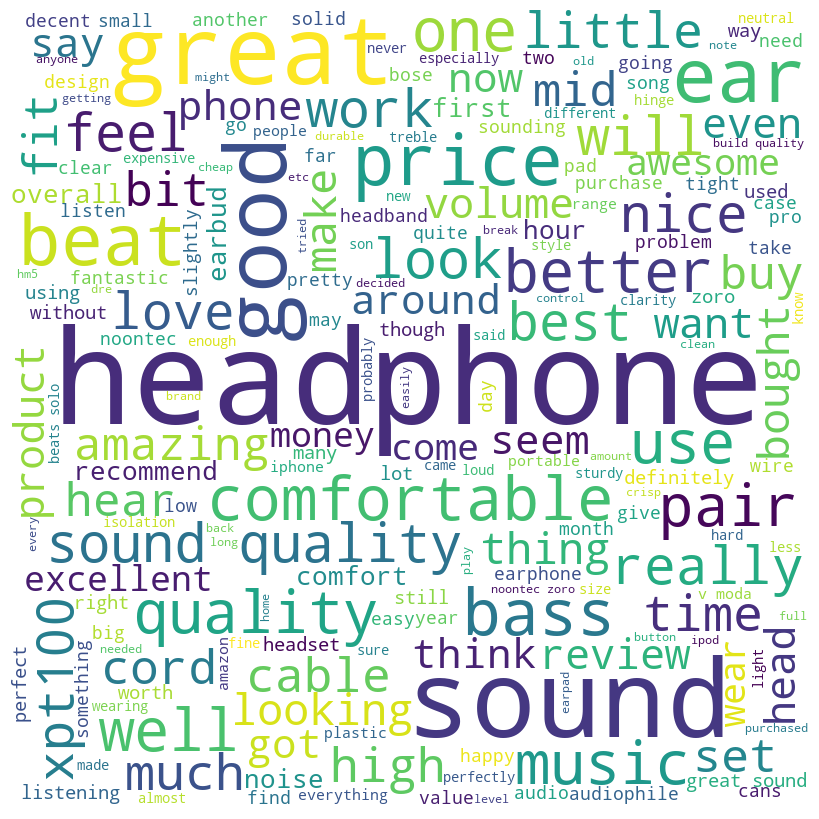

In [34]:
#depicting areas which are good using wordcloud 
#the sie of the phrase indicates frequency and hence importance of issues since most of the users agree with it
wordcloud_good = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(review_words_good) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_good) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

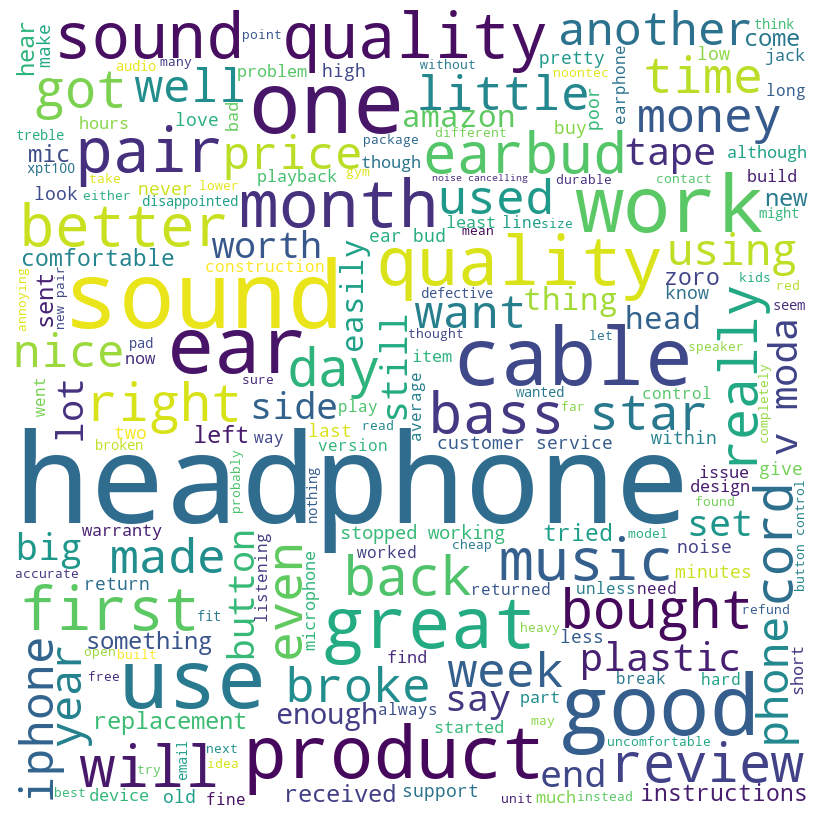

In [35]:
#depicting areas which need to improve using wordcloud 

wordcloud_bad = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(review_words_bad) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_bad) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 
# Note ; the recommendation part could have been applied on Amazon's data as well since we had the meta data of the product 
#but another online retail dataset was chosen just to show diversity

In [36]:
#Link for the datasets: http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/